In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import pandas as pd

import dgl
import numpy as np
import torch as th
from dgl.nn import EdgeGATConv

%matplotlib inline

#torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [2]:
import pickle
with open('subgraph.pkl', 'rb') as file:
    subgraph = pickle.load(file)

In [3]:
subgraph.ndata['feature']=subgraph.ndata['feature'].to(torch.float32)
subgraph.edata['feature']=subgraph.edata['feature'].to(torch.float32)

In [4]:
import networkx as nx
G=dgl.to_networkx(subgraph)
A=nx.to_scipy_sparse_matrix(G, format='csr')
A

<10693x10693 sparse matrix of type '<class 'numpy.intc'>'
	with 1458949 stored elements in Compressed Sparse Row format>

In [5]:
from scipy.sparse import csr_matrix
X=csr_matrix(subgraph.ndata['feature'].cpu().numpy())
X

<10693x112 sparse matrix of type '<class 'numpy.float32'>'
	with 173392 stored elements in Compressed Sparse Row format>

In [6]:
df = pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz', header=None, names=['species_id'])

In [7]:
df = pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz', header=None, names=['species_id'])
selected_species=[4932,511145]

df_selected_species = df[df['species_id'].isin(selected_species)]

affiliation_matrix = pd.get_dummies(df_selected_species, columns=['species_id']).groupby(level=0, axis=1).max()

C:\Users\ACT\AppData\Local\Temp\ipykernel_2548\1961254491.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  affiliation_matrix = pd.get_dummies(df_selected_species, columns=['species_id']).groupby(level=0, axis=1).max()


In [8]:
Z_gt=affiliation_matrix.astype('int').values
orG = G
N, K = Z_gt.shape

In [9]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

In [10]:
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

c:\Users\ACT\Desktop\overlapping-community-detection\nocd\utils.py:35: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:620.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, shape)


In [11]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.EdgeGATConv(
    in_feats=112,
    edge_feats=8,
    out_feats=2,
    num_heads=1,
    feat_drop=0,
    attn_drop=0,
    negative_slope=0.2,
    residual=True,
    activation=None,
    allow_zero_in_degree=True,
    bias=True
)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [12]:
graph=subgraph
node_feats=subgraph.ndata['feature']
edge_feats=subgraph.edata['feature']

In [13]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(graph, node_feats, edge_feats))
    Z= Z.view(-1, Z.size(2))
    Z_pred = Z.cpu().detach().numpy() > thresh

    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [14]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

print('loop start')

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            print('before evaluation...')
            gnn.eval()
            print('after evaluation...')
            # Compute validation loss
            Z = F.relu(gnn(graph, node_feats, edge_feats))
            Z_reshaped = Z.view(-1, Z.size(2))
            print('z calculated...')
            # print(Z)
            val_loss = decoder.loss_full(Z_reshaped, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    # print('before_train...')
    gnn.train()
    # print('after train...')
    opt.zero_grad()
    Z = F.relu(gnn(graph, node_feats, edge_feats))
    # print('get Z')
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()
    # print('done')

loop start
before evaluation...
after evaluation...
z calculated...
Epoch    0, loss.full = 0.9930, nmi = 0.01
before evaluation...
after evaluation...
z calculated...
Epoch   25, loss.full = 1.1830, nmi = 0.01
before evaluation...
after evaluation...
z calculated...
Epoch   50, loss.full = 0.9463, nmi = 0.01
before evaluation...
after evaluation...
z calculated...
Epoch   75, loss.full = 0.9241, nmi = 0.01
before evaluation...
after evaluation...
z calculated...
Epoch  100, loss.full = 0.8894, nmi = 0.01
before evaluation...
after evaluation...
z calculated...
Epoch  125, loss.full = 0.8688, nmi = 0.00
before evaluation...
after evaluation...
z calculated...
Epoch  150, loss.full = 0.8474, nmi = 0.00
before evaluation...
after evaluation...
z calculated...
Epoch  175, loss.full = 0.8356, nmi = 0.00
before evaluation...
after evaluation...
z calculated...
Epoch  200, loss.full = 0.8266, nmi = 0.00
before evaluation...
after evaluation...
z calculated...
Epoch  225, loss.full = 0.8192, 

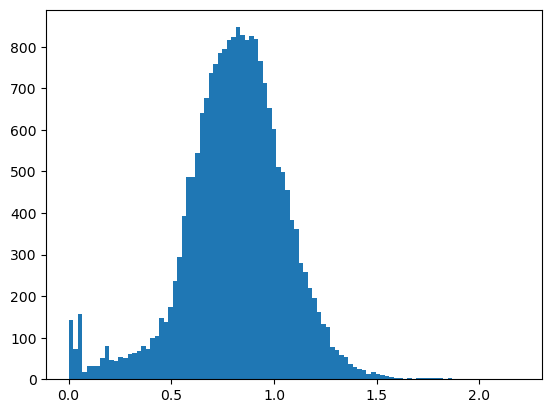

In [15]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [16]:
thresh = 0.5

Z = F.relu(gnn(graph, node_feats, edge_feats))
Z= Z.view(-1, Z.size(2))
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.006


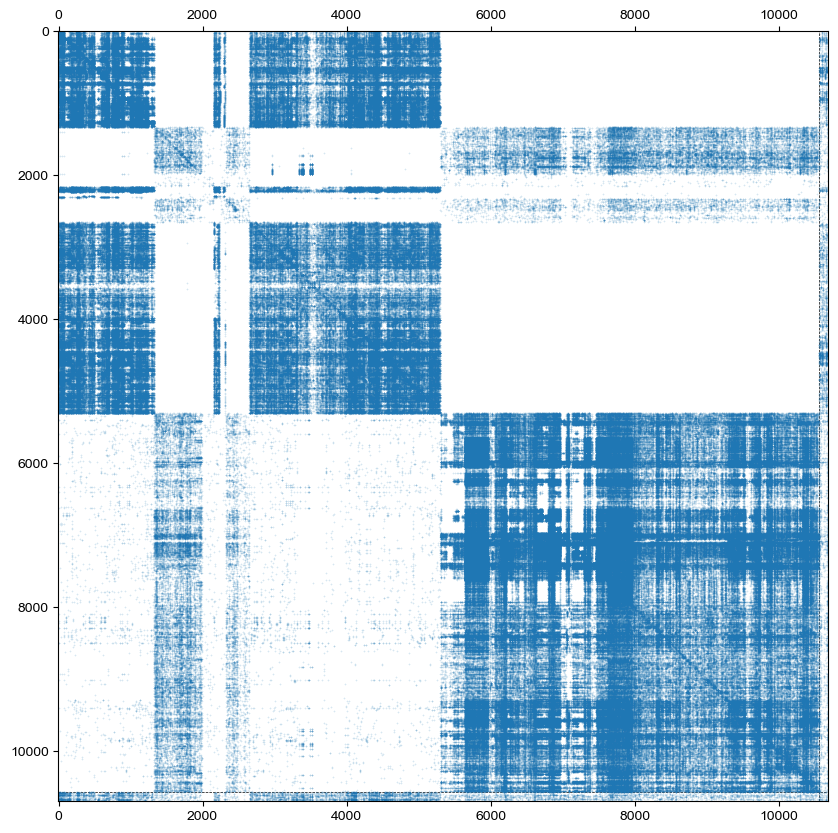

In [17]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [18]:
# Sizes of detected communities
print(Z_pred.sum(0))

[9881 9584]


In [19]:
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

c:\Users\ACT\Desktop\overlapping-community-detection\nocd\metrics\unsupervised.py:29: RuntimeWarning: overflow encountered in scalar multiply
  possible = (n - 2) * (n - 1) * n / 6


Ground truth communities:
 - coverage    = 0.9962
 - conductance = 0.0040
 - density     = 2.517e-02
 - clust_coef  = 0.000e+00


In [20]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9814
 - conductance = 0.0275
 - density     = 1.478e-02
 - clust_coef  = 0.000e+00


In [21]:
Z_gt

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [22]:
Z_pred

array([[False, False],
       [ True, False],
       [ True,  True],
       ...,
       [False, False],
       [ True,  True],
       [ True, False]])

In [23]:
different_values_count = np.sum(Z_pred[:, 0] != Z_pred[:, 1])
different_values_count

551

In [24]:
def get_comlist(community_matrix):
    transposed_matrix = np.transpose(community_matrix)

    # Initialize an empty list to store tuples (community_id, nodes_list)
    community_nodes_list = []

    # Iterate through rows (communities)
    for community_id, community_row in enumerate(transposed_matrix):
        # Find nodes (columns) where the value is 1
        community_nodes = np.where(community_row == 1)[0].tolist()
        
        # Append a tuple to the list containing community ID and nodes list
        community_nodes_list.append(community_nodes)
    
    return community_nodes_list

In [25]:
from cdlib import algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'graph_tool', 'wurlitzer', 'bayanpy', 'infomap'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg', 'infomap'}


In [26]:
from cdlib import NodeClustering
from cdlib import evaluation

coms1=get_comlist(Z_gt)
coms2=get_comlist(Z_pred)

communities1=NodeClustering(coms1,G)
communities2=NodeClustering(coms2,G)

onmi=evaluation.overlapping_normalized_mutual_information_LFK(communities1,communities2)
print(onmi)

MatchingResult(score=0.011769983573240217, std=None)
